##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Save and load models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/save_and_load"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Model progress can be saved during and after training. This means a model can resume where it left off and avoid long training times. Saving also means you can share your model and others can recreate your work. When publishing research models and techniques, most machine learning practitioners share:

* code to create the model, and
* the trained weights, or parameters, for the model

Sharing this data helps others understand how the model works and try it themselves with new data.

Caution: TensorFlow models are code and it is important to be careful with untrusted code. See [Using TensorFlow Securely](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md) for details.

### Options

There are different ways to save TensorFlow models depending on the API you're using. This guide uses [tf.keras](https://www.tensorflow.org/guide/keras)—a high-level API to build and train models in TensorFlow. For other approaches, refer to the [Using the SavedModel format guide](../../guide/saved_model.ipynb) and the [Save and load Keras models guide](https://www.tensorflow.org/guide/keras/save_and_serialize).

## Setup

### Installs and imports

Install and import TensorFlow and dependencies:

In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.2


### Get an example dataset

To demonstrate how to save and load weights, you'll use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). To speed up these runs, use the first 1000 examples:

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

11501568/11490434 [==============================] - 1s 0us/step


### Define a model

Start by building a simple sequential model:

In [4]:
# Define a simple sequential model
def create_model():
  model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Save checkpoints during training

You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The `tf.keras.callbacks.ModelCheckpoint` callback allows you to continually save the model both *during* and at *the end* of training.

### Checkpoint callback usage

Create a `tf.keras.callbacks.ModelCheckpoint` callback that saves weights only during training:

In [27]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

tbCallbacks = [
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=1,
embeddings_freq=1,
)
]
# Train the model with the new callback
history = model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          #weightCallbacks=[cp_callback]  # Pass callback to training
          callbacks=tbCallbacks)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
32/32 [==============================] - 0s 15ms/step - loss: 0.1140 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8650
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.4212 - val_sparse_categorical_accuracy: 0.8700
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.4076 - val_sparse_categorical_accuracy: 0.8710
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.4090 - val_sparse_categorical_accuracy: 0.8700
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.4193 - val_sparse_categorical_accuracy: 0.8720
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0290 - sparse_categorical_accurac

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch:

In [6]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights. 

Now rebuild a fresh, untrained model and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy):

In [7]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 2.4216 - sparse_categorical_accuracy: 0.0620 - 230ms/epoch - 7ms/step
Untrained model, accuracy:  6.20%


Then load the weights from the checkpoint and re-evaluate:

In [8]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4160 - sparse_categorical_accuracy: 0.8690 - 120ms/epoch - 4ms/step
Restored model, accuracy: 86.90%


### Checkpoint callback options

The callback provides several options to provide unique names for checkpoints and adjust the checkpointing frequency.

Train a new model, and save uniquely named checkpoints once every five epochs:

In [9]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
modelFitHistory = model.fit(train_images, 
          train_labels,
          epochs=20, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to training_2/cp-0005.ckpt

Epoch 10: saving model to training_2/cp-0010.ckpt

Epoch 15: saving model to training_2/cp-0015.ckpt

Epoch 20: saving model to training_2/cp-0020.ckpt


Now, review the resulting checkpoints and choose the latest one:

In [10]:
os.listdir(checkpoint_dir)

['cp-0005.ckpt.index',
 'checkpoint',
 'cp-0020.ckpt.index',
 'cp-0020.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0015.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.data-00000-of-00001']

In [11]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0020.ckpt'

Note: The default TensorFlow format only saves the 5 most recent checkpoints.

To test, reset the model, and load the latest checkpoint:

In [12]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4310 - sparse_categorical_accuracy: 0.8790 - 135ms/epoch - 4ms/step
Restored model, accuracy: 87.90%


## What are these files?

The above code stores the weights to a collection of [checkpoint](../../guide/checkpoint.ipynb)-formatted files that contain only the trained weights in a binary format. Checkpoints contain:
* One or more shards that contain your model's weights.
* An index file that indicates which weights are stored in which shard.

If you are training a model on a single machine, you'll have one shard with the suffix: `.data-00000-of-00001`

## Manually save weights

To save weights manually, use `tf.keras.Model.save_weights`. By default, `tf.keras`—and the `Model.save_weights` method in particular—uses the TensorFlow [Checkpoint](../../guide/checkpoint.ipynb) format with a `.ckpt` extension. To save in the HDF5 format with a `.h5` extension, refer to the [Save and load models](https://www.tensorflow.org/guide/keras/save_and_serialize) guide.

In [13]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4310 - sparse_categorical_accuracy: 0.8790 - 152ms/epoch - 5ms/step
Restored model, accuracy: 87.90%


## Save the entire model

Call `tf.keras.Model.save` to save a model's architecture, weights, and training configuration in a single `file/folder`. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (`SavedModel` and `HDF5`). The TensorFlow `SavedModel` format is the default file format in TF2.x. However, models can be saved in `HDF5` format. More details on saving entire models in the two file formats is described below.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js ([Saved Model](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model), [HDF5](https://www.tensorflow.org/js/tutorials/conversion/import_keras)) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite ([Saved Model](https://www.tensorflow.org/lite/models/convert/#convert_a_savedmodel_recommended_), [HDF5](https://www.tensorflow.org/lite/models/convert/#convert_a_keras_model_))

\*Custom objects (for example, subclassed models or layers) require special attention when saving and loading. Refer to the **Saving custom objects** section below.

### SavedModel format

The SavedModel format is another way to serialize models. Models saved in this format can be restored using `tf.keras.models.load_model` and are compatible with TensorFlow Serving. The [SavedModel guide](../../guide/saved_model.ipynb) goes into detail about how to `serve/inspect` the SavedModel. The section below illustrates the steps to save and restore the model.

In [14]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 1.1448 - sparse_categorical_accuracy: 0.6730
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8790
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.9250
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9480
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9650


The SavedModel format is a directory containing a protobuf binary and a TensorFlow checkpoint. Inspect the saved model directory:

In [15]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


Reload a fresh Keras model from the saved model:

In [16]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               401920    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


The restored model is compiled with the same arguments as the original model. Try running evaluate and predict with the loaded model:

In [17]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

32/32 - 0s - loss: 0.4262 - sparse_categorical_accuracy: 0.8640 - 147ms/epoch - 5ms/step
Restored model, accuracy: 86.40%
(1000, 10)


### HDF5 format

Keras provides a basic save format using the [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) standard. 

In [18]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') 

Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 1.1556 - sparse_categorical_accuracy: 0.6710
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.4276 - sparse_categorical_accuracy: 0.8880
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.9160
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9410
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.9700


Now, recreate the model from that file:

In [19]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               401920    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Check its accuracy:

In [20]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

32/32 - 0s - loss: 0.4501 - sparse_categorical_accuracy: 0.8510 - 141ms/epoch - 4ms/step
Restored model, accuracy: 85.10%


Keras saves models by inspecting their architectures. This technique saves everything:

* The weight values
* The model's architecture
* The model's training configuration (what you pass to the `.compile()` method)
* The optimizer and its state, if any (this enables you to restart training where you left off)

Keras is not able to save the `v1.x` optimizers (from `tf.compat.v1.train`) since they aren't compatible with checkpoints. For v1.x optimizers, you need to re-compile the model after loading—losing the state of the optimizer.


### Saving custom objects

If you are using the SavedModel format, you can skip this section. The key difference between HDF5 and SavedModel is that HDF5 uses object configs to save the model architecture, while SavedModel saves the execution graph. Thus, SavedModels are able to save custom objects like subclassed models and custom layers without requiring the original code.

To save custom objects to HDF5, you must do the following:

1. Define a `get_config` method in your object, and optionally a `from_config` classmethod.
  * `get_config(self)` returns a JSON-serializable dictionary of parameters needed to recreate the object.
  * `from_config(cls, config)` uses the returned config from `get_config` to create a new object. By default, this function will use the config as initialization kwargs (`return cls(**config)`).
2. Pass the object to the `custom_objects` argument when loading the model. The argument must be a dictionary mapping the string class name to the Python class. E.g. `tf.keras.models.load_model(path, custom_objects={'CustomLayer': CustomLayer})`

Refer to the [Writing layers and models from scratch](https://www.tensorflow.org/guide/keras/custom_layers_and_models) tutorial for examples of custom objects and `get_config`.


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


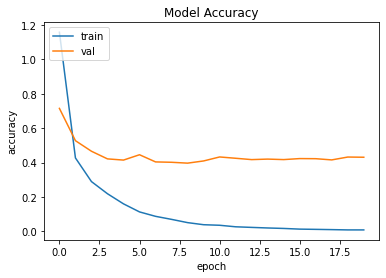

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fefbe179ed0>>

In [22]:
# Plot training vs validation
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(modelFitHistory.history['loss'])
plt.plot(modelFitHistory.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.summary